In [1]:
# Imports
from collections import deque
import itertools
import pandas as pd
import requests
import numpy as np
import seaborn as sns
import time
from IPython.core.display import display, HTML
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from IPython.display import clear_output


%matplotlib inline

In [2]:
# Function to make a request and parse the HTML
def make_request():
    url = 'https://qweather.gov.qa/CAA/EWSData.aspx'

    headers = {
        'User-Agent': 'Daniel bot',
        'From': 'brankd@gmail.com'
    }

    # Create a session object to persist cookies
    session = requests.Session()

    # Make the request using the session object
    response = session.get(url, headers=headers)

    # Check the status code to ensure the request was successful
    if response.status_code == 200:
        # Parse the whole HTML page using BeautifulSoup
        url_soup = BeautifulSoup(response.text, 'html.parser')
        return url_soup
    else:
        print(f"Request failed with status code: {response.status_code}")
        return None


In [3]:
# Function to extract data from HTML and update the history
def extract_and_update_history(url_soup, data_history):
    
    # Find the time and date of wind data
    date_div = url_soup.find('div', class_='inner-title-2')
    date_value = date_div.get_text(strip=True)

    # Parse the string into a datetime object
    date_time_obj = datetime.strptime(date_value, '%B %d, %Y %H:%M')

    # Format the datetime object to get the time
    time_only = date_time_obj.strftime('%H:%M')
    
    # Loop over the table rows, collect the data, and store them in a list
    data_list = []
    for row in url_soup.find_all('tr')[1:]:
        row_data = [data.text.strip() for data in row.find_all('td')[:5]]
        station_name = row_data[0]
        data_values = row_data[1:]

        # Create a dictionary for each row
        row_dict = {'Time': time_only, 'Station': station_name, 'Temperature': data_values[0], 'Humidity': data_values[1],
                    'Wind Speed': data_values[2], 'Wind Direction': data_values[3]}

        data_list.append(row_dict)

    # Convert the list of dictionaries to a Pandas DataFrame
    df = pd.DataFrame(data_list)

    # Append the DataFrame to the data history
    data_history.append(df)

    # Keep only the last 144 entries in the history (24 hours)
    data_history = data_history[-144:]
    #data_history = data_history[-3:]

    return data_history

In [4]:
# Function to plot wind speed for a specific station
def plot_wind_speed(data_history, station_name):
    # Combine all DataFrames in the data history
    combined_df = pd.concat(data_history, ignore_index=True)

    # Filter data for the specified station
    station_df = combined_df[combined_df['Station'] == station_name].copy()

    # Convert 'Wind Speed' column to numeric using .loc
    station_df.loc[:, 'Wind Speed'] = pd.to_numeric(station_df['Wind Speed'], errors='coerce')

    # Ensure the index is a DatetimeIndex
    station_df.index = pd.to_datetime(station_df.index)

    # Calculate rolling average over the last hour (6 data points)
    station_df['Rolling Average'] = station_df['Wind Speed'].rolling(window=6, min_periods=1).mean()

    # Clear the previous figure
    plt.clf()
    plt.close()
    
    # Clear the cell output
    clear_output(wait=True)

    # Plot the data using Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))

    # Convert the DatetimeIndex to a formatted time string
    #station_df['Time'] = station_df.index.strftime('%H:%M:%S')

    # Plot the wind speed with actual time on x-axis
    sns.scatterplot(x='Time', y='Wind Speed', data=station_df, label=f'{station_name} (Points)')

    # Plot the rolling average
    sns.lineplot(x='Time', y='Rolling Average', data=station_df, label='Rolling Average', linestyle='--')

    plt.title(f'Wind Speed and Rolling Average for Station: {station_name}')
    plt.xlabel('Time')
    plt.ylabel('Wind Speed')
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.legend()
    plt.show()
    
    

In [5]:
# # Main loop for testing
# data_history = []  # Initialize a list for data history

# # Define the duration for which the loop should run (in seconds)
# duration_seconds = 6

# # Get the current time
# start_time = time.time()

# while time.time() - start_time < duration_seconds:
#     # Make a new request and parse the HTML
#     url_soup = make_request()

#     if url_soup:
#         # Extract data and update history
#         data_history = extract_and_update_history(url_soup, data_history)

#         # Print or process the current data
#         # (In this case, we'll plot wind speed for a specific station)
#         plot_wind_speed(data_history, 'Abu Samra') 

#     # Wait for a certain interval before making the next request
#     time.sleep(2)  # Sleep for 10 minutes

# print("Loop finished after 10 seconds.")

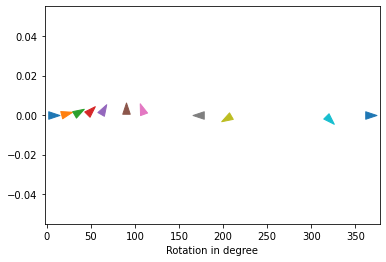

In [6]:
# Plot rotated  arrows for each point

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt



def gen_arrow_head_marker(rot):
    """generate a marker to plot with matplotlib scatter, plot, ...

    https://matplotlib.org/stable/api/markers_api.html#module-matplotlib.markers

    rot=0: positive x direction
    Parameters
    ----------
    rot : float
        rotation in degree
        0 is positive x direction

    Returns
    -------
    arrow_head_marker : Path
        use this path for marker argument of plt.scatter
    scale : float
        multiply a argument of plt.scatter with this factor got get markers
        with the same size independent of their rotation.
        Paths are autoscaled to a box of size -1 <= x, y <= 1 by plt.scatter
    """
    arr = np.array([[.1, .3], [.1, -.3], [1, 0], [.1, .3]])  # arrow shape
    angle = rot / 180 * np.pi
    rot_mat = np.array([
        [np.cos(angle), np.sin(angle)],
        [-np.sin(angle), np.cos(angle)]
        ])
    arr = np.matmul(arr, rot_mat)  # rotates the arrow

    # scale
    x0 = np.amin(arr[:, 0])
    x1 = np.amax(arr[:, 0])
    y0 = np.amin(arr[:, 1])
    y1 = np.amax(arr[:, 1])
    scale = np.amax(np.abs([x0, x1, y0, y1]))
    codes = [mpl.path.Path.MOVETO, mpl.path.Path.LINETO,mpl.path.Path.LINETO, mpl.path.Path.CLOSEPOLY]
    arrow_head_marker = mpl.path.Path(arr, codes)
    return arrow_head_marker, scale

fig, ax = plt.subplots()
for rot in [0, 15, 30, 45, 60, 90, 110, 180, 210, 315, 360]:

    marker, scale = gen_arrow_head_marker(rot)
    markersize = 25
    ax.scatter(rot, 0, marker=marker, s=(markersize*scale)**2)

ax.set_xlabel('Rotation in degree')

plt.show()

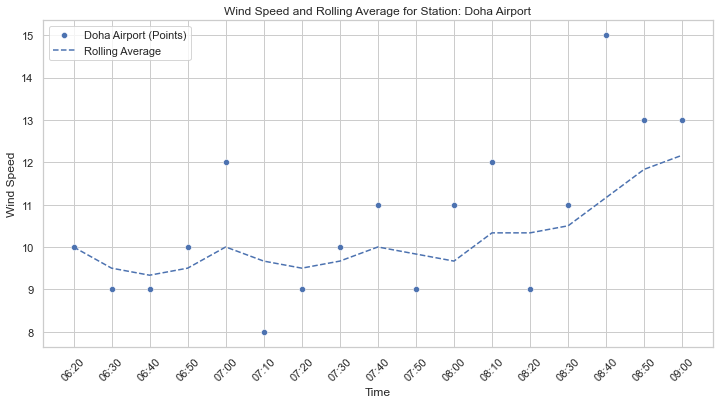

In [8]:
# Main loop
data_history = []  # Initialize a list for data history

while True:
    # Make a new request and parse the HTML
    url_soup = make_request()

    if url_soup:
        # Extract data and update history
        data_history = extract_and_update_history(url_soup, data_history)

        # Print the current data
        # (In this case, we'll plot wind speed for a specific station)
        plot_wind_speed(data_history, 'Doha Airport') 

    # Wait for a certain interval before making the next request
    time.sleep(600)  # Sleep for 10 minutes
    